In [1]:
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

import itertools

import awkward as ak
import numpy as np

from apps import cex_analyse, cex_toy_parameters
from python.analysis import cross_section, Master, Plots
from rich import print
cross_section.SetPlotStyle(True, dpi = 100)

def PlotObservableComparison(inputs : dict[cross_section.AnalysisInput], obs : str, bins, xlabel : str):
    tags = {k : cross_section.Tags.ExclusiveProcessTags(v.exclusive_process) for k, v in inputs.items()}    
    x = (bins[1:] + bins[:-1]) / 2

    styles = CreateStyles()

    for _, k in Plots.IterMultiPlot(list(tags.values())[0]):
        for e, i in enumerate(inputs):
            hist = np.histogram(getattr(inputs[i], obs)[tags[i][k].mask], bins)[0]
            Plots.Plot(x, hist/sum(hist), yerr = np.sqrt(hist)/sum(hist), color = f"C{2*e}", style = styles[e % len(styles)][0], marker = styles[e % len(styles)][1], linestyle = styles[e % len(styles)][2], label = i, title = k, newFigure = False)
        Plots.plt.xlabel(xlabel)
        Plots.plt.ylabel("fractional counts")
    return


def PlotMCToyComparison(mc : cross_section.AnalysisInput, toy : cross_section.AnalysisInput, obs : str, bins, xlabel : str):
    tags_mc = cross_section.Tags.ExclusiveProcessTags(mc.exclusive_process)
    tags_toy = cross_section.Tags.ExclusiveProcessTags(toy.exclusive_process)
    x = (bins[1:] + bins[:-1]) / 2
    for _, k in Plots.IterMultiPlot(tags_mc):
        h_m = np.histogram(getattr(mc, obs)[tags_mc[k].mask], bins)[0]
        h_t = np.histogram(getattr(toy, obs)[tags_toy[k].mask], bins)[0]
        Plots.Plot(x, h_m/sum(h_m), yerr = np.sqrt(h_m)/sum(h_m), style = "step", color = tags_mc[k].colour, label = "MC", newFigure = False)
        Plots.Plot(x, h_t/sum(h_t), yerr = np.sqrt(h_t)/sum(h_t), marker = "o", color = tags_toy[k].colour, label = "toy", linestyle = "", xlabel = xlabel, ylabel = "fractional counts", title = k, newFigure = False)
    return


def PlotAnalysisInputRatio(data1 : cross_section.AnalysisInput, data2 : cross_section.AnalysisInput, observable : str, bins : np.array, xlabel : str = None, ratio_label : str = "data2/data1", label_1 : str = "data 1", label_2 : str = "data 2", norm : float = None, weights_1 : np.array = None, weights_2 : np.array = None):
    if norm is None:
        count_1 = len(data1.inclusive_process) if weights_1 is None else sum(weights_1)
        count_2 = len(data2.inclusive_process) if weights_2 is None else sum(weights_2)
        norm = count_2/count_1
    # print(f"{count_2, count_1, count_2/count_1=}")
    h_1 = np.array(np.histogram(getattr(data1, observable), bins, weights = weights_1)[0] * norm, dtype = int)
    h_2 = np.histogram(getattr(data2, observable), bins, weights = weights_2)[0]
    with Plots.RatioPlot(bin_centers(bins), h_1, h_2, np.sqrt(h_1), np.sqrt(h_2), xlabel, ratio_label) as ratio_plot:
        Plots.Plot(ratio_plot.x, ratio_plot.y2, yerr = ratio_plot.y2_err, label=f"{label_2}: {sum(ratio_plot.y2)}", style = "step", color = "C6", newFigure = False)
        Plots.Plot(ratio_plot.x, ratio_plot.y1, yerr = ratio_plot.y1_err, label=f"{label_1}: {sum(ratio_plot.y1)}", marker = "x", linestyle = "", color = "k", ylabel = "Counts", newFigure = False)
        
        h, l = Plots.plt.gca().get_legend_handles_labels()
        Plots.plt.legend(h + [Plots.matplotlib.patches.Rectangle((0,0), 0, 0, fill = False, edgecolor='none', visible=False)], l + [f"norm: {norm:.3g}"], loc = "best", ncols = 1, labelspacing = 0.25,  columnspacing = 0.25)


def CreateStyles():
    style = ["step", "scatter"]
    marker = [None, "o", "x", "+"]
    linestyle = ["", "-", "--", "-."]

    styles = itertools.product(style, marker, linestyle)
    selected_styles = []
    for s in styles:
        if (s[0] == "step") and (s[1] is None) and (s[2] != ""): selected_styles.append(s)
        if (s[0] == "scatter") and (s[1] is None) and (s[2] != ""): selected_styles.append(s)
        if (s[0] == "scatter") and (s[1] is not None) and (s[2] == ""): selected_styles.append(s)

    selected_styles = selected_styles[:3] + selected_styles[6:] + selected_styles[3:6]
    selected_styles = selected_styles[::3] + selected_styles[1::3] + selected_styles[2::3]
    return selected_styles


def bin_centers(bins : np.array) -> np.array:
    return (bins[1:] + bins[:-1]) / 2


def CreateAnalysisInputMCTrueBeam(mc : Master.Data, args : cross_section.argparse.Namespace):
    is_pip = mc.trueParticles.pdg[:, 0] == 211
    mc_true_beam = mc.Filter([is_pip], [is_pip], True)

    n_pi =  cross_section.EventSelection.SelectionTools.GetPFOCounts(args.selection_masks["mc"]["pi"])
    n_pi0 = cross_section.EventSelection.SelectionTools.GetPFOCounts(args.selection_masks["mc"]["pi0"])
    reco_regions = cross_section.EventSelection.create_regions_new(n_pi0, n_pi)


    n_pi_true = mc_true_beam.trueParticles.nPiMinus + mc_true_beam.trueParticles.nPiPlus
    n_pi0_true = mc_true_beam.trueParticles.nPi0
    true_regions = cross_section.EventSelection.create_regions_new(n_pi0_true, n_pi_true)

    return cross_section.AnalysisInput.CreateAnalysisInputNtuple(mc_true_beam, args.upstream_loss_correction_params["value"], reco_regions, true_regions)

env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


In [2]:
config = "work/2023/cex_analysis_1GeV_config.json"
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
analysis_input_toy_template = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(file = args.toy_template))

energy_slices = cross_section.Slices(50, 0, 1050, True)
mean_track_score_bins = np.linspace(0, 1, 21, True)
create_mc = False

In [3]:
if create_mc == True:
    mc = Master.Data(args.mc_file, nTuple_type = args.ntuple_type)
    analysis_input_mc_s = cex_analyse.CreateAnalysisInput(mc, args, True) # beam particle selection
    analysis_input_mc = CreateAnalysisInputMCTrueBeam(mc, args) # truth beam (reco regions won't work)

    analysis_input_mc = analysis_input_mc.ToFile("test/analysis_inputs/analysis_input_1GeV_mc_cheated.dill")
    analysis_input_mc_s = analysis_input_mc_s.ToFile("test/analysis_inputs/analysis_input_1GeV_mc_selected.dill")
else:
    analysis_input_mc = cross_section.AnalysisInput.FromFile("test/analysis_inputs/analysis_input_1GeV_mc_cheated.dill")
    analysis_input_mc_s =  cross_section.AnalysisInput.FromFile("test/analysis_inputs/analysis_input_1GeV_mc_selected.dill")


In [4]:
config = {
    "events" : 144230,
    "step" : 0.5,
    "p_init" : 1000,
    "beam_profile" : "gaussian",
    # "beam_profile" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/beam_profile/beam_profile.json",
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_ff_resolution.json",
        "KE_int" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int_resolution.json",
        "z_int" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/track_length_resolution.json"
    },
    "reco_region_fractions" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "mean_track_score_kde" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/meanTrackScoreKDE/kdes.dill",
    "pdf_scale_factors" : None,
    "df_format" : "f",
    "modified_PDFs" : None,
    "verbose" : None,
    "seed" : None,
    "max_cpus" : 11
}

In [5]:
toy = cross_section.Toy(file = "work/2023/toys/xs_toy_1GeV_gaussian_60MeV_PDSP_stats.hdf5")
analysis_input_toy = cex_analyse.CreateAnalysisInput(toy, args, True) # without selection efficiency

# Comparing 1GeV toy and MC

In [6]:
def proportions(analysis_input : cross_section.AnalysisInput):
    output = {}
    output["inel"] = sum(analysis_input.exclusive_process["pion_production"]) / len(analysis_input.exclusive_process["pion_production"])
    output["charge_exchange"] = sum(analysis_input.exclusive_process["pion_production"]) / sum(analysis_input.exclusive_process["charge_exchange"])
    output["absorption"] = sum(analysis_input.exclusive_process["pion_production"]) / sum(analysis_input.exclusive_process["absorption"])
    output["single_pion_production"] = sum(analysis_input.exclusive_process["pion_production"]) / sum(analysis_input.exclusive_process["single_pion_production"])
    print(output)

proportions(cex_analyse.CreateAnalysisInput(cross_section.Toy(file = "work/2023/toys/xs_toy_1GeV_gaussian_60MeV_PDSP_stats.hdf5"), args, True, False))
proportions(analysis_input_toy)
proportions(analysis_input_mc)

# {s
#     'inel': 0.15439229009221384,
#     'charge_exchange': 1.0427046263345197,
#     'absorption': 0.5477174340810704,
#     'single_pion_production': 0.37737895503923263
# }

{
    'inel': 0.1506136032725508,
    'charge_exchange': 1.02520175562792,
    'absorption': 0.5234583965878696,
    'single_pion_production': 0.36955190364397267
}

{
    'inel': 0.1506136032725508,
    'charge_exchange': 1.02520175562792,
    'absorption': 0.5234583965878696,
    'single_pion_production': 0.36955190364397267
}

{
    'inel': 0.16915343548498926,
    'charge_exchange': 1.2378608757420468,
    'absorption': 0.5699301516107179,
    'single_pion_production': 0.42565033061744334
}

np.sum(counts, 1)/np.sum(counts)=array([0.28125639, 0.14577604, 0.41157754, 0.16139003])

np.sum(counts, 1)/np.sum(counts)=array([0.28981165, 0.14797511, 0.41050889, 0.15170434])

np.sum(counts, 1)/np.sum(counts)=array([0.29464939, 0.14800904, 0.41017602, 0.14716555])

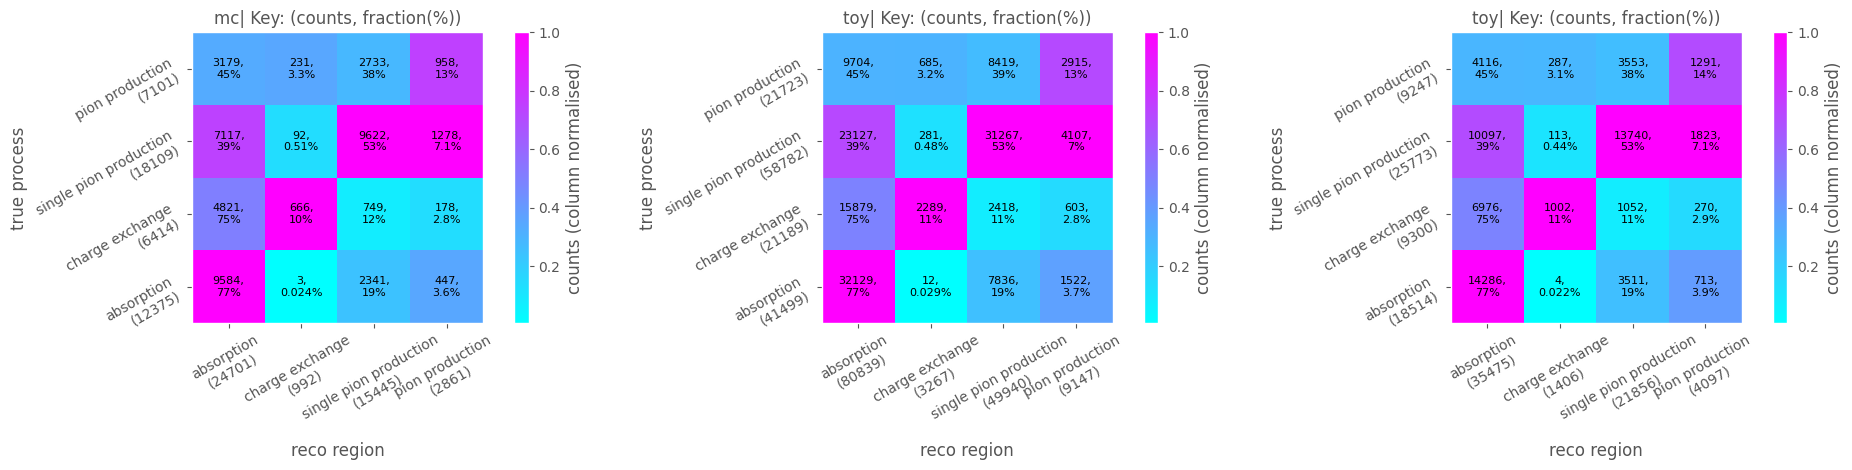

In [7]:
plot = Plots.MultiPlot(3)
next(plot)
counts = cross_section.Toy.ComputeCounts(analysis_input_mc_s.exclusive_process, analysis_input_mc_s.regions)
print(f"{np.sum(counts, 1)/np.sum(counts)=}")
cex_toy_parameters.PlotCorrelationMatrix(counts, list(analysis_input_mc_s.exclusive_process.keys()), list(analysis_input_mc_s.regions.keys()), "mc", newFigure = False)
next(plot)
counts = cross_section.Toy.ComputeCounts(analysis_input_toy.exclusive_process, analysis_input_toy.regions)
print(f"{np.sum(counts, 1)/np.sum(counts)=}")
cex_toy_parameters.PlotCorrelationMatrix(counts, list(analysis_input_toy.exclusive_process.keys()), list(analysis_input_toy.regions.keys()), "toy", newFigure = False)
next(plot)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


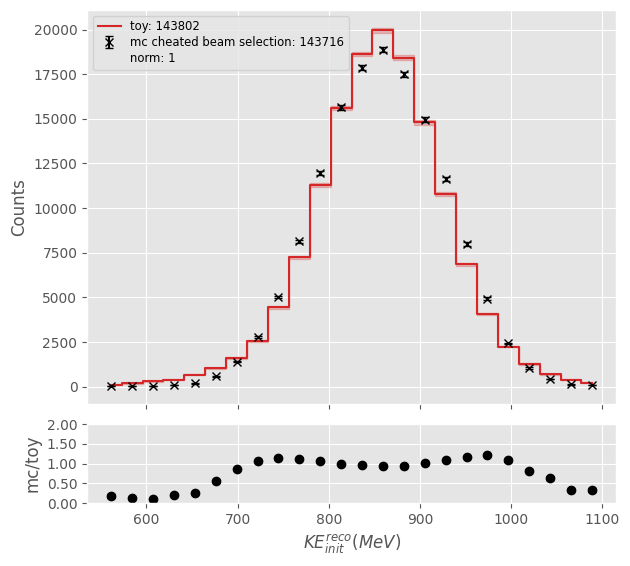

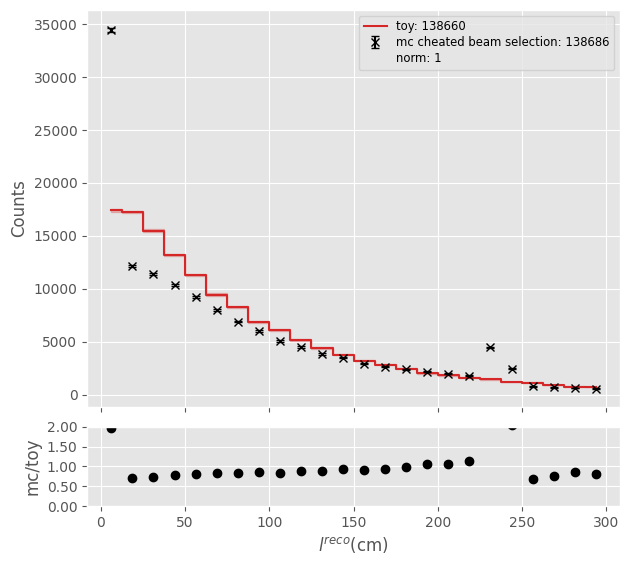

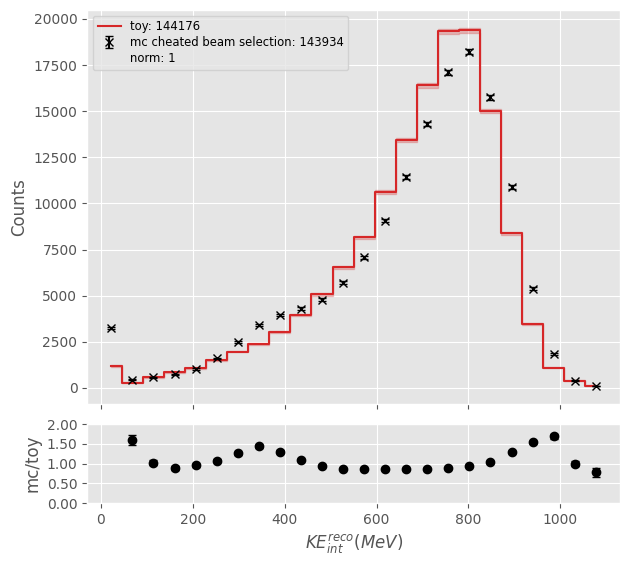

In [9]:
with Plots.PlotBook("toy_vs_cheated_selection.pdf", False) as book:
    PlotAnalysisInputRatio(analysis_input_mc, analysis_input_toy, "KE_init_reco", np.linspace(550, 1100, 25), "$KE_{init}^{reco}(MeV)$", "mc/toy", "mc cheated beam selection", "toy")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc, analysis_input_toy, "track_length_reco", np.linspace(0, 300, 25), "$l^{reco}$(cm)", "mc/toy", "mc cheated beam selection", "toy")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc, analysis_input_toy, "KE_int_reco", np.linspace(0, 1100, 25), "$KE_{int}^{reco}(MeV)$", "mc/toy", "mc cheated beam selection", "toy")
    book.Save()

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1592: RuntimeWarning: invalid value encountered in divide
  ratio_err = abs(ratio * np.sqrt((self.y1_err/self.y1)**2 + (self.y2_err/self.y2)**2))


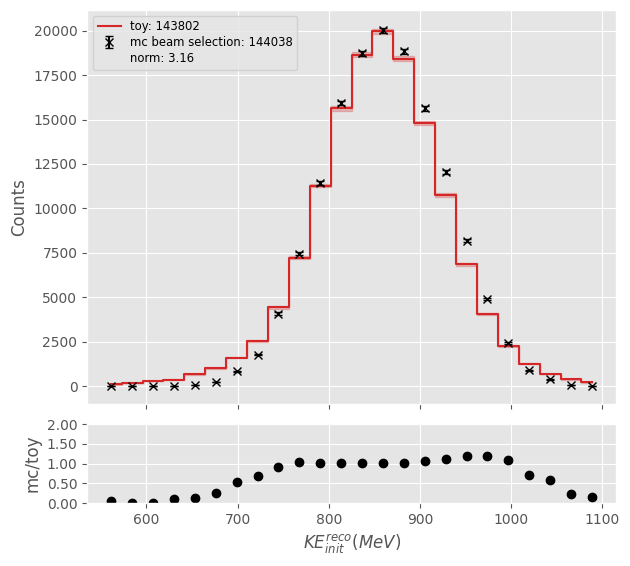

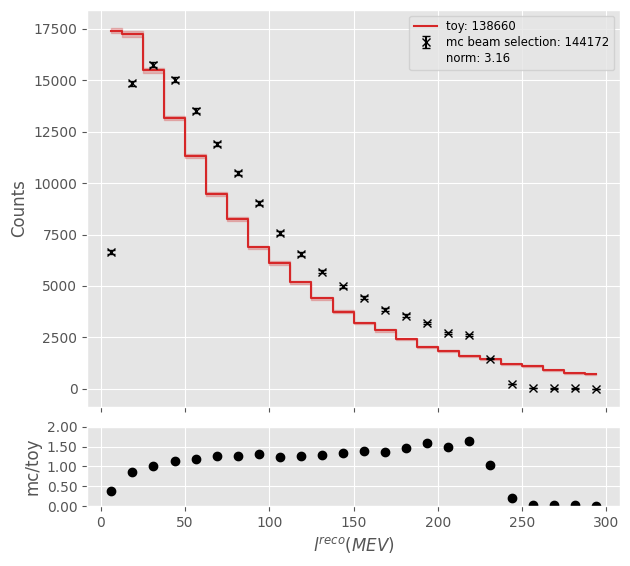

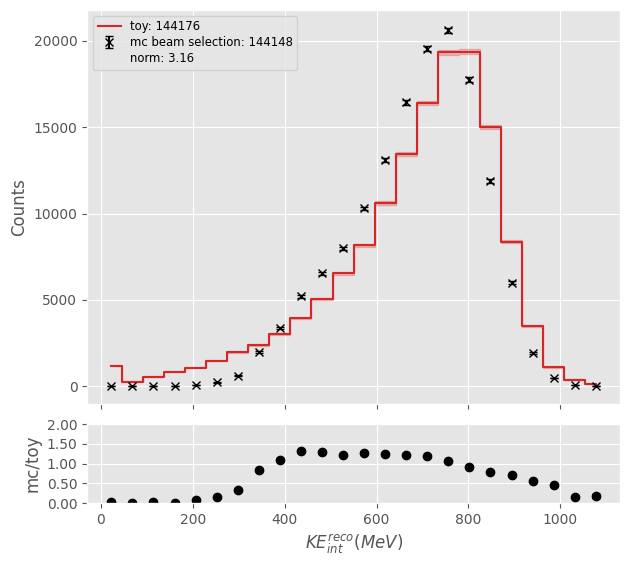

In [10]:
with Plots.PlotBook("toy_vs_beam_selection.pdf", False) as book:
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy, "KE_init_reco", np.linspace(550, 1100, 25), "$KE_{init}^{reco}(MeV)$", "mc/toy", "mc beam selection", "toy")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy, "track_length_reco", np.linspace(0, 300, 25), "$l^{reco}(MEV)$", "mc/toy", "mc beam selection", "toy")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy, "KE_int_reco", np.linspace(0, 1100, 25), "$KE_{int}^{reco}(MeV)$", "mc/toy", "mc beam selection", "toy")
    book.Save()

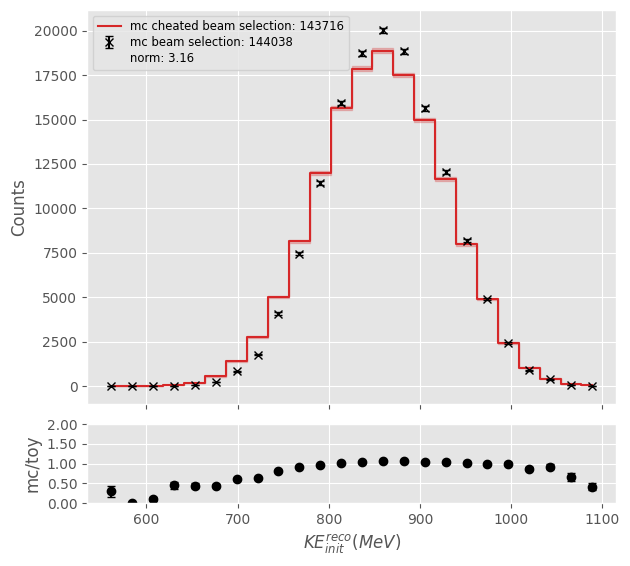

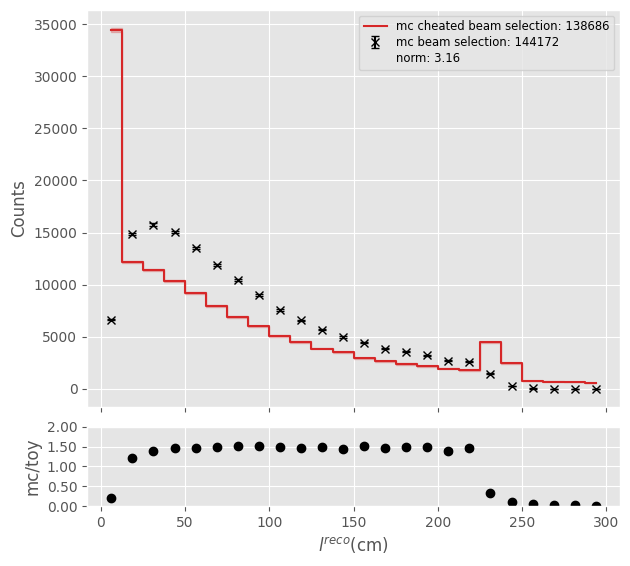

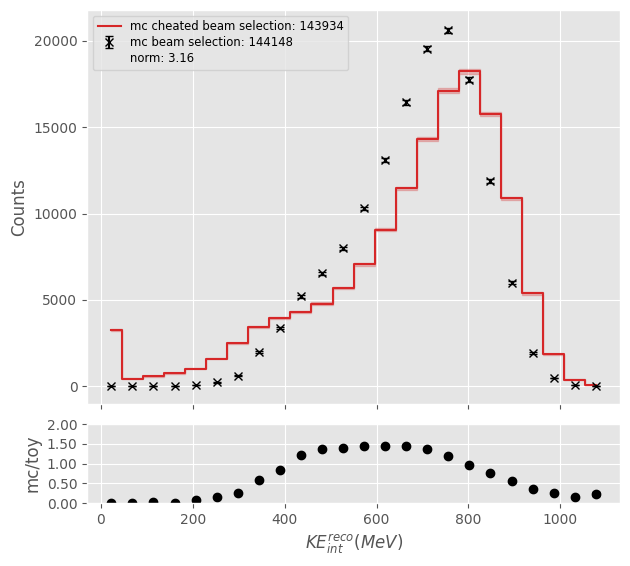

In [12]:
with Plots.PlotBook("beam_selection_vs_cheated_selection.pdf", False) as book:
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_mc, "KE_init_reco", np.linspace(550, 1100, 25), "$KE_{init}^{reco}(MeV)$", "mc/toy", "mc beam selection", "mc cheated beam selection")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_mc, "track_length_reco", np.linspace(0, 300, 25), "$l^{reco}$(cm)", "mc/toy", "mc beam selection", "mc cheated beam selection")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_mc, "KE_int_reco", np.linspace(0, 1100, 25), "$KE_{int}^{reco}(MeV)$", "mc/toy", "mc beam selection", "mc cheated beam selection")
    book.Save()

In [14]:
print({k : sum(v) / len(v) for k, v in analysis_input_mc_s.regions.items()})
print({k : sum(v) / len(v) for k, v in analysis_input_toy.regions.items()})

{
    'absorption': 0.5419143941554595,
    'charge_exchange': 0.021763454070775103,
    'single_pion_production': 0.3388473267370176,
    'pion_production': 0.06276738114565279
}

{
    'absorption': 0.5604867225958539,
    'charge_exchange': 0.022651320807044305,
    'single_pion_production': 0.34625251334673784,
    'pion_production': 0.06341953823753727
}

 - alter the proportion of processes in toy to match MC, redo fit

 - perfect reweight of toy template?
 - selection efficiency weights per exclusive process

# Efficiency Weights

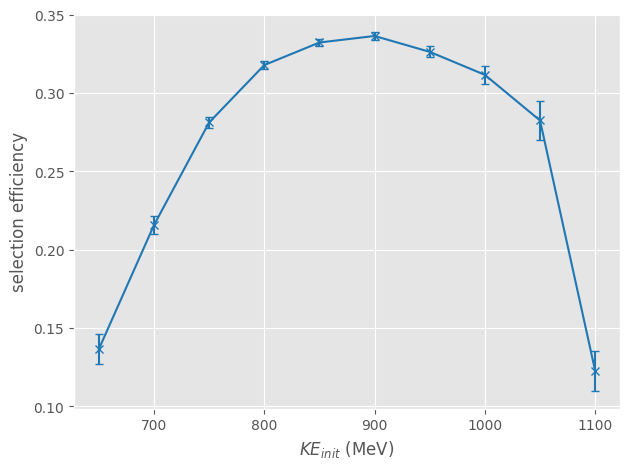

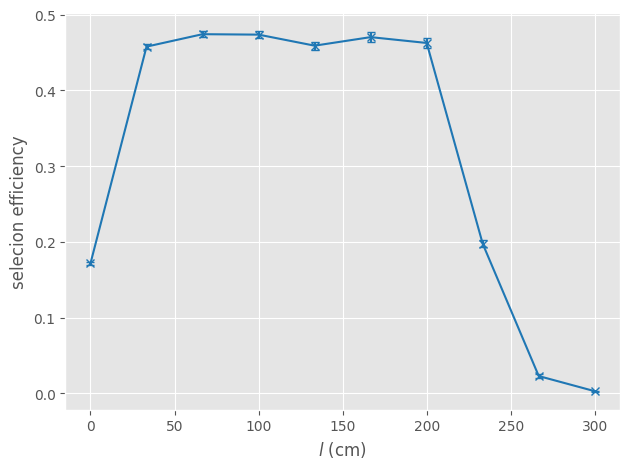

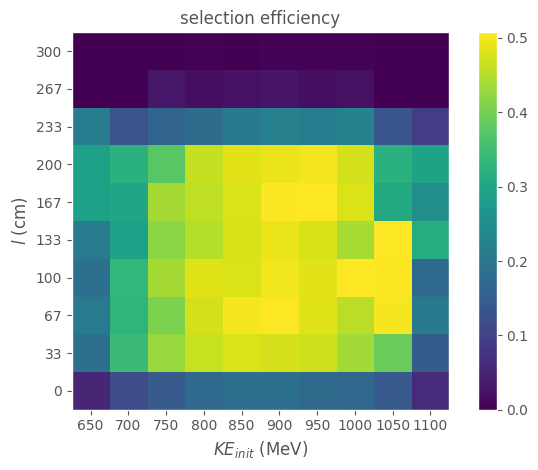

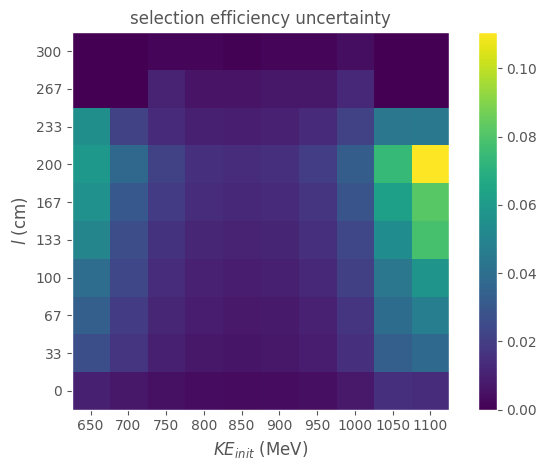

In [15]:
def MakeMatrix(analysis_input : cross_section.AnalysisInput, bins : int, x_range, y_range, process : str = None):
    
    l = analysis_input.track_length_reco[analysis_input.exclusive_process[process]] if process is not None else analysis_input.track_length_reco
    e = analysis_input.KE_init_reco[analysis_input.exclusive_process[process]] if process is not None else analysis_input.KE_init_reco

    x = np.array(np.clip(l, min(x_range), max(x_range)))
    y = np.array(np.clip(e, min(y_range), max(y_range)))
    return np.histogram2d(x, y, bins = bins, range = [x_range, y_range])[0]

def EfficiencyMatrix(data_selected, data_cheated, bins : int, track_length_range = [0, 300], KE_init_range = [650, 1100], process : str = None, book : Plots.PlotBook = None):
    h_selected = MakeMatrix(data_selected, bins, track_length_range, KE_init_range, process)
    h_cheated = MakeMatrix(data_cheated, bins, track_length_range, KE_init_range, process)
    # fractions = h_selected / h_cheated

    fractions, errors = cex_toy_parameters.Efficiency(h_selected, h_cheated)

    fractions = np.where(np.isnan(fractions), 0, fractions)
    fractions = np.where(abs(fractions) == np.inf, 0, fractions)

    bins_KE = np.linspace(*KE_init_range, bins)
    bins_trklen = np.linspace(*track_length_range, bins)

    f, e = cex_toy_parameters.Efficiency(np.sum(h_selected, 0), np.sum(h_cheated, 0))
    Plots.Plot(bins_KE, f, yerr = e, marker = "x", xlabel = "$KE_{init}$ (MeV)", ylabel = "selection efficiency")
    if book is not None: book.Save()

    f, e = cex_toy_parameters.Efficiency(np.sum(h_selected, 1), np.sum(h_cheated, 1))
    Plots.Plot(bins_trklen, f, yerr = e, marker = "x", xlabel = "$l$ (cm)", ylabel = "selecion efficiency")
    if book is not None: book.Save()

    KE_ticks = [f"{i:.0f}" for i in bins_KE]
    trklen_ticks = [f"{i:.0f}" for i in bins_trklen]

    Plots.plt.figure()
    Plots.plt.imshow(fractions, origin = "lower") #extent = (650, 1100, 0, 300), aspect = (1100 - 650)/(300 - 0))
    Plots.plt.colorbar()

    Plots.plt.gca().set_xticks(np.arange(len(bins_KE)), labels=KE_ticks)
    Plots.plt.gca().set_yticks(np.arange(len(bins_trklen)), labels=trklen_ticks)
    Plots.plt.xlabel("$KE_{init}$ (MeV)")
    Plots.plt.ylabel("$l$ (cm)")
    Plots.plt.grid(False)
    Plots.plt.title("selection efficiency")
    Plots.plt.tight_layout()
    if book is not None: book.Save()

    Plots.plt.figure()
    Plots.plt.imshow(errors, origin = "lower") #extent = (650, 1100, 0, 300), aspect = (1100 - 650)/(300 - 0))
    Plots.plt.colorbar()

    Plots.plt.gca().set_xticks(np.arange(len(bins_KE)), labels=KE_ticks)
    Plots.plt.gca().set_yticks(np.arange(len(bins_trklen)), labels=trklen_ticks)
    Plots.plt.xlabel("$KE_{init}$ (MeV)")
    Plots.plt.ylabel("$l$ (cm)")
    Plots.plt.grid(False)
    Plots.plt.title("selection efficiency uncertainty")
    Plots.plt.tight_layout()
    if book is not None: book.Save()


    return fractions

fractions = EfficiencyMatrix(analysis_input_mc_s, analysis_input_mc, 10)

In [16]:
def CreateWeights(KE_init_reco, track_length_reco, weights_matrix, bins):
    column_ind = np.digitize(np.clip(KE_init_reco, 650, 1100), np.linspace(650, 1100, bins)) - 1
    row_ind = np.digitize(np.clip(track_length_reco, 0, 300), np.linspace(0, 300, bins)) - 1
    toy_weights = weights_matrix.flatten()[(row_ind * bins) + column_ind]
    return toy_weights

toy_weights = CreateWeights(analysis_input_toy_template.KE_init_reco, analysis_input_toy_template.track_length_reco, fractions, 10)

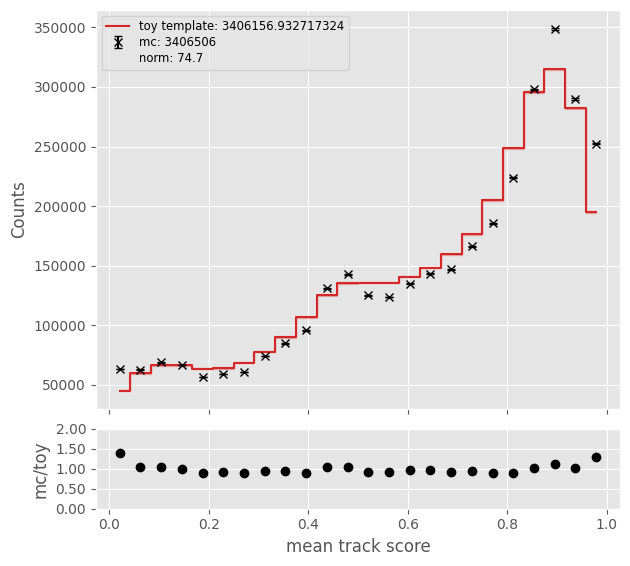

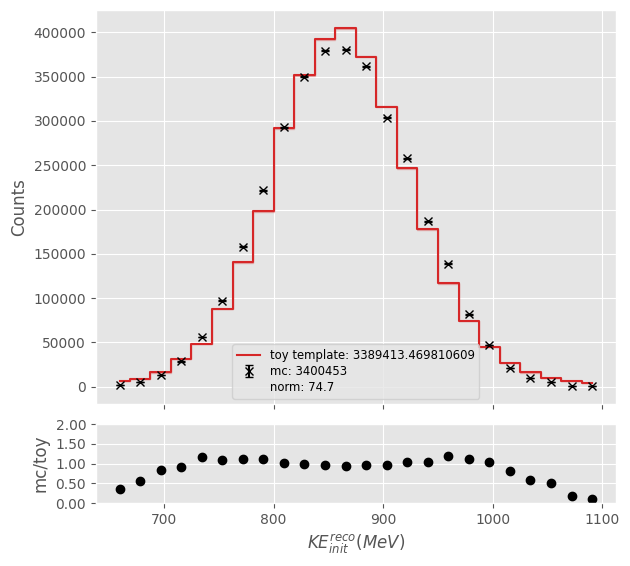

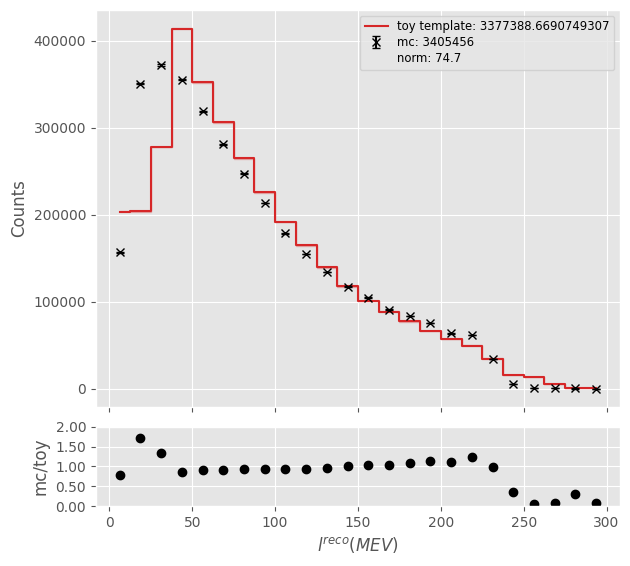

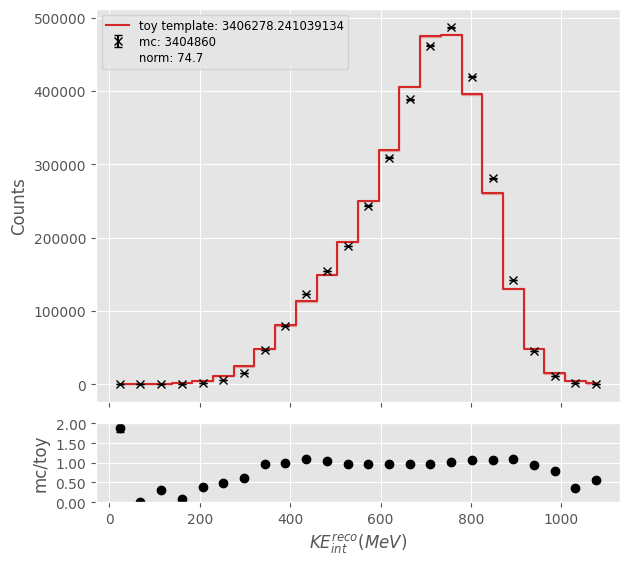

In [17]:
with Plots.PlotBook("ratio_plot_weighted.pdf", False) as book:
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy_template, "mean_track_score", np.linspace(0, 1, 25), "mean track score", "mc/toy", "mc", "toy template", weights_2 = toy_weights)
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy_template, "KE_init_reco", np.linspace(650, 1100, 25), "$KE_{init}^{reco}(MeV)$", "mc/toy", "mc", "toy template", weights_2 = toy_weights)
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy_template, "track_length_reco", np.linspace(0, 300, 25), "$l^{reco}(MEV)$", "mc/toy", "mc", "toy template", weights_2 = toy_weights)
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy_template, "KE_int_reco", np.linspace(0, 1100, 25), "$KE_{int}^{reco}(MeV)$", "mc/toy", "mc", "toy template", weights_2 = toy_weights)
    book.Save()


# Region Fit

In [18]:
def CompareFitResults(region_fit_result, analysis_input : cross_section.AnalysisInput, book : Plots.PlotBook = None):
    KE_int_prediction = cross_section.RegionFit.SliceModelPrediction(region_fit_result, slice(-1), "KE_int_postfit") # exclude the channel which is the mean track score

    total_yield_KE = np.sum(np.sum(KE_int_prediction.model_yields, 0), 1)

    print(f"{total_yield_KE, sum(total_yield_KE)=}")

    actual_yield_KE = []

    for _, (n, n_err, k) in Plots.IterMultiPlot(list(zip(np.sum(KE_int_prediction.model_yields, 0), np.sum(KE_int_prediction.total_stdev_model_bins[:, :-1], 0), analysis_input.exclusive_process.keys()))):
        true = cross_section.EnergySlice.CountingExperiment(analysis_input.KE_int_reco, analysis_input.KE_init_reco, analysis_input.outside_tpc_reco, analysis_input.exclusive_process[k], energy_slices, True)
        Plots.Plot(np.array(range(len(n))), true, label = "actual", style = "bar", color = "C6", title = f"MC | {k}", xlabel = "$N_{int}$", newFigure = False)
        Plots.Plot(np.array(range(len(n))), n, yerr = n_err, label = "fit", style = "step", color = "k", newFigure = False)
        actual_yield_KE.append(np.sum(true))
    if book: book.Save()

    print(f"{actual_yield_KE, sum(actual_yield_KE)=}")

    track_score_prediction = cross_section.RegionFit.SliceModelPrediction(region_fit_result, slice(4, 5), "mean_track_score_post")

    total_yield_score = np.sum(track_score_prediction.model_yields[0], 1)
    print(f"{total_yield_score, sum(total_yield_score)=}")

    track_scores_actual = [analysis_input.mean_track_score[analysis_input.exclusive_process[k]] for k in analysis_input.exclusive_process]

    actual_yield_score = [len(i) for i in track_scores_actual]
    print(f"{actual_yield_score, sum(actual_yield_score)=}")

    labels = list(analysis_input.exclusive_process.keys())

    Plots.plt.figure()
    for i in range(len(track_score_prediction.model_yields[0])):
        Plots.PlotHist(track_scores_actual[i], bins = mean_track_score_bins, histtype = "step", color = f"C{(2*i)}", label = labels[i], xlabel = "mean track score", newFigure = False)
        Plots.Plot((mean_track_score_bins[1:] + mean_track_score_bins[:-1]) / 2, track_score_prediction.model_yields[0][i], yerr = track_score_prediction.total_stdev_model_bins[0][i], label = "fit", color = f"C{(2*i+1)}", newFigure = False)
    if book: book.Save()

    for i in Plots.MultiPlot(len(track_score_prediction.model_yields[0])):
        Plots.PlotHist(track_scores_actual[i], bins = mean_track_score_bins, histtype = "bar", color = f"C6", label = "actual", xlabel = "mean track score", title = labels[i], newFigure = False)
        Plots.Plot((mean_track_score_bins[1:] + mean_track_score_bins[:-1]) / 2, track_score_prediction.model_yields[0][i], yerr = track_score_prediction.total_stdev_model_bins[0][i], label = "fit", color = "k", style = "step", newFigure = False)
    if book: book.Save()

    return

## MC template

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 23, 'channel_1': 23, 'channel_2': 23, 'channel_3': 23, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_sample_0_pois_err', 'shapesys'), ('channel_0_sample_1_pois_err', 'shapesys'), ('channel_0_sample_2_pois_err', 'shapesys'), ('channel_0_sample_3_pois_err', 'shapesys'), ('channel_1_sample_0_pois_err', 'shapesys'), ('channel_1_sample_1_pois_err', 'shapesys'), ('channel_1_sample_2_pois_err', 'shapesys'), ('channel_1_sample_3_pois_err', 'shapesys'), ('channel_2_sample_0_pois_err', 'shapesys'), ('channel_2_sample_1_pois_err', 'shapesys'), ('channel_2_sample_2_pois_err', 'shapesys'), ('channel_2_sample_3_pois_err', 'shapesys'), ('channel_3_sample_0_pois_err', 'shapesys'), ('channel_3_sample_1_pois_err', 'shapesys'), ('channel_3_sample_2_pois_err', 'shapesys'), ('channel_3_sample_3_pois_err', 'shapesys'), ('mean_track_sco

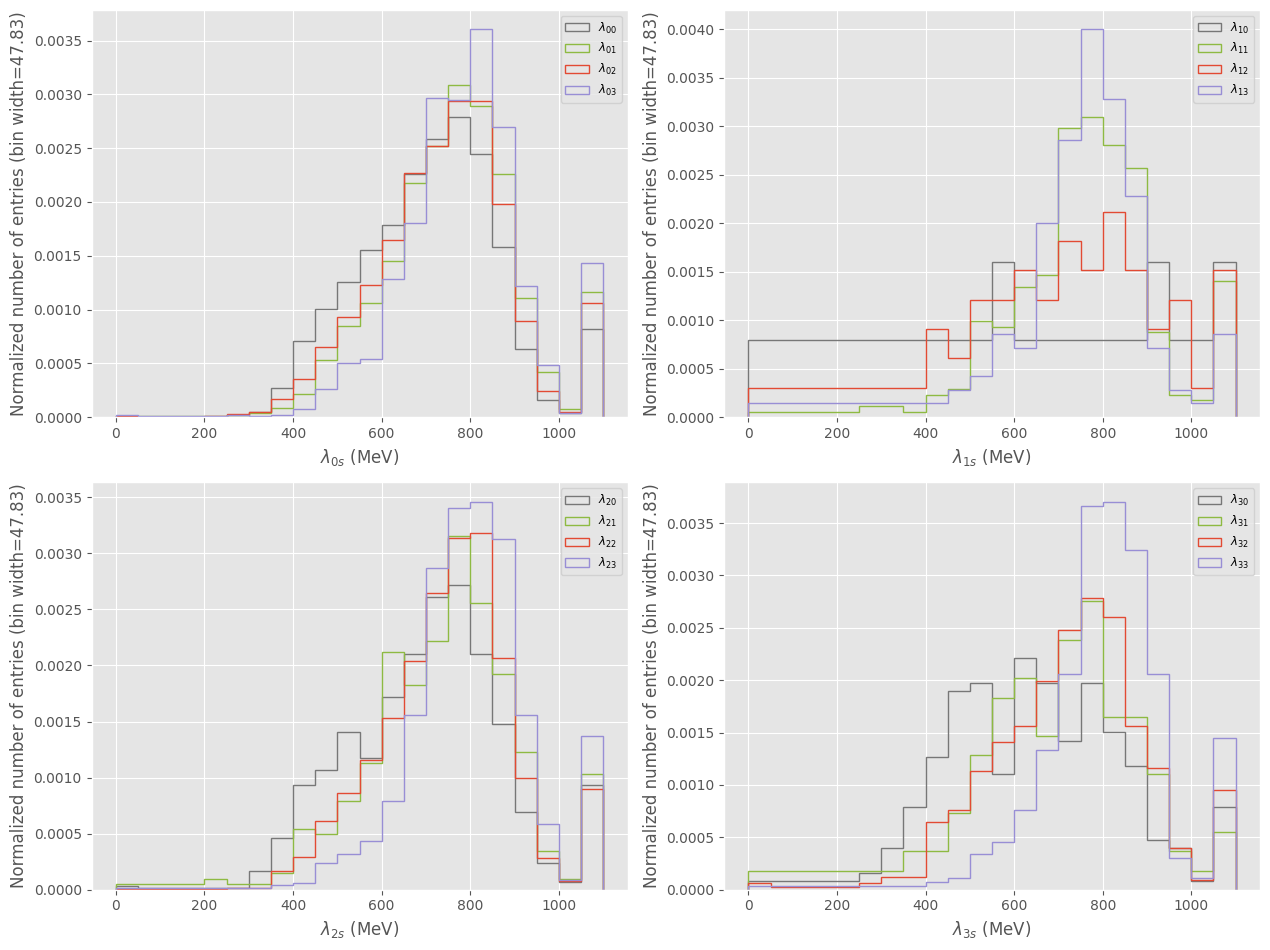

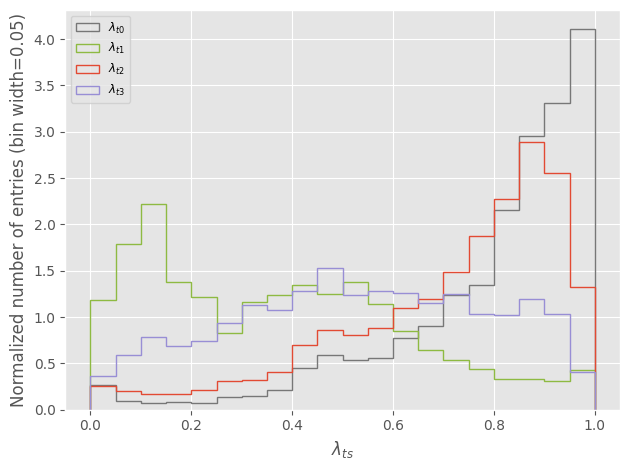

In [19]:
def RegionFitMC(fit_input : cross_section.AnalysisInput, energy_slice : cross_section.Slices, mean_track_score_bins : np.array, template : cross_section.AnalysisInput, suggest_init : bool = False) -> cross_section.cabinetry.model_utils.ModelPrediction:

    model = cross_section.RegionFit.CreateModel(template, energy_slice, mean_track_score_bins, False)

    observed = cross_section.RegionFit.GenerateObservations(fit_input, energy_slice, mean_track_score_bins, model)

    if suggest_init is True:
        init_params = cex_analyse.CreateInitParams(model, fit_input, energy_slice, mean_track_score_bins)
    else:
        init_params = None

    result = cross_section.RegionFit.Fit(observed, model, init_params, verbose = True)
    return cross_section.cabinetry.model_utils.prediction(model, fit_results = result)


energy_overflow =  np.insert(energy_slices.pos, 0, energy_slices.max_pos + energy_slices.width) # xlabels for KE, which has an overflow bin (max energy + energy bin width) 
energy_bins = np.sort(energy_overflow)

analysis_input_mc_split = cross_section.AnalysisInput.CreateTrainTestSamples(analysis_input_mc_s, 1, 0.5)
model, templates_energy, templates_mean_track_score = cross_section.RegionFit.CreateModel(analysis_input_mc_split["train"], energy_slices, mean_track_score_bins, True)

tags = cross_section.Tags.ExclusiveProcessTags(analysis_input_mc_split["train"].exclusive_process)
for j, c in Plots.IterMultiPlot(templates_energy):
    for i, s in enumerate(c):
        Plots.PlotHist(energy_overflow, energy_bins, weights = s, color = tags.number[i].colour, label = f"$\lambda_{{{j}{i}}}$", xlabel = f"$\lambda_{{{j}s}}$ (MeV)", histtype = "step", newFigure = False, density = True)

Plots.plt.figure()
for i, s in enumerate(templates_mean_track_score):
    Plots.PlotHist(bin_centers(mean_track_score_bins), mean_track_score_bins, weights = s, color = tags.number[i].colour, label = f"$\lambda_{{t{i}}}$", xlabel = f"$\lambda_{{ts}}$", histtype = "step", newFigure = False, density = True)
Plots.plt.legend(loc = "upper left")

template size 22790, data size 22791

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 23, 'channel_1': 23, 'channel_2': 23, 'channel_3': 23, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_sample_0_pois_err', 'shapesys'), ('channel_0_sample_1_pois_err', 'shapesys'), ('channel_0_sample_2_pois_err', 'shapesys'), ('channel_0_sample_3_pois_err', 'shapesys'), ('channel_1_sample_0_pois_err', 'shapesys'), ('channel_1_sample_1_pois_err', 'shapesys'), ('channel_1_sample_2_pois_err', 'shapesys'), ('channel_1_sample_3_pois_err', 'shapesys'), ('channel_2_sample_0_pois_err', 'shapesys'), ('channel_2_sample_1_pois_err', 'shapesys'), ('channel_2_sample_2_pois_err', 'shapesys'), ('channel_2_sample_3_pois_err', 'shapesys'), ('channel_3_sample_0_pois_err', 'shapesys'), ('channel_3_sample_1_pois_err', 'shapesys'), ('channel_3_sample_2_pois_err', 'shapesys'), ('channel_3_sample_3_pois_err', 'shapesys'), ('mean_track_sco

total_yield_KE, sum(total_yield_KE)=(array([6428.76241975, 3149.10806591, 8922.23570063, 3777.73782314]), 
22277.844009430555)

actual_yield_KE, sum(actual_yield_KE)=([6133, 3352, 8928, 3549], 21962)

total_yield_score, sum(total_yield_score)=(array([6469.84938932, 3165.73848194, 9034.27461287, 3805.29677197]), 
22475.15925610684)

actual_yield_score, sum(actual_yield_score)=([6133, 3352, 8928, 3549], 21962)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


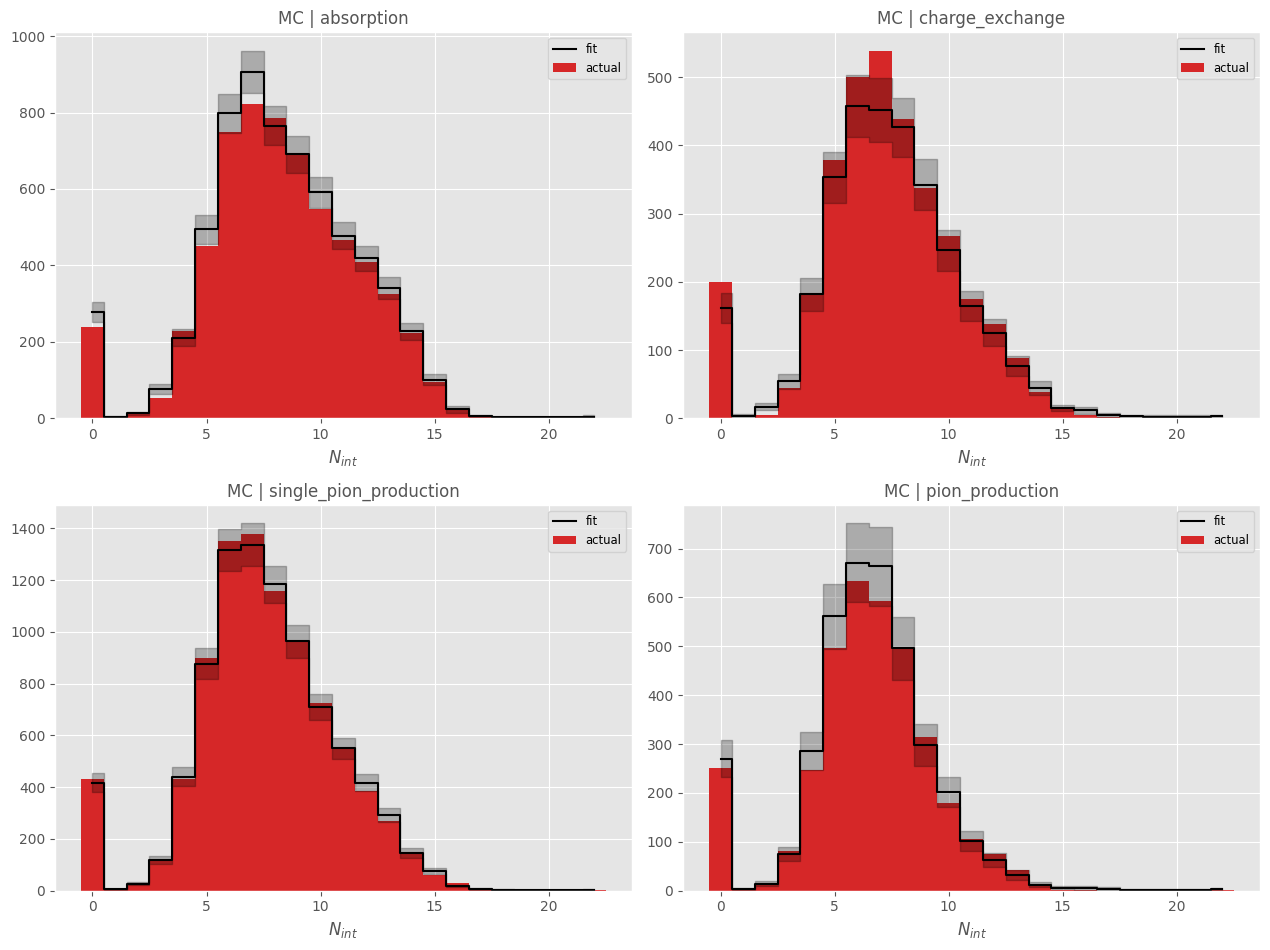

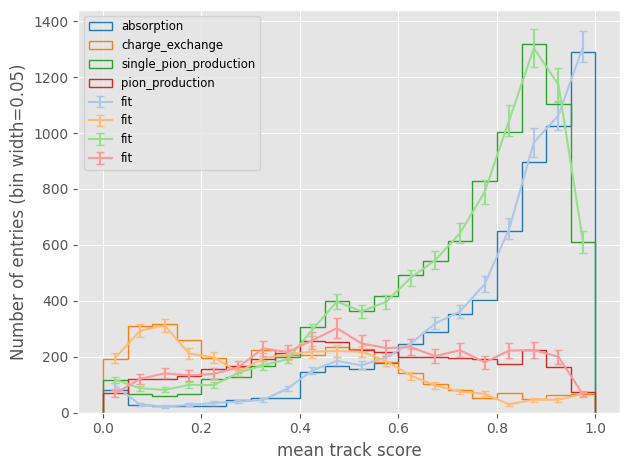

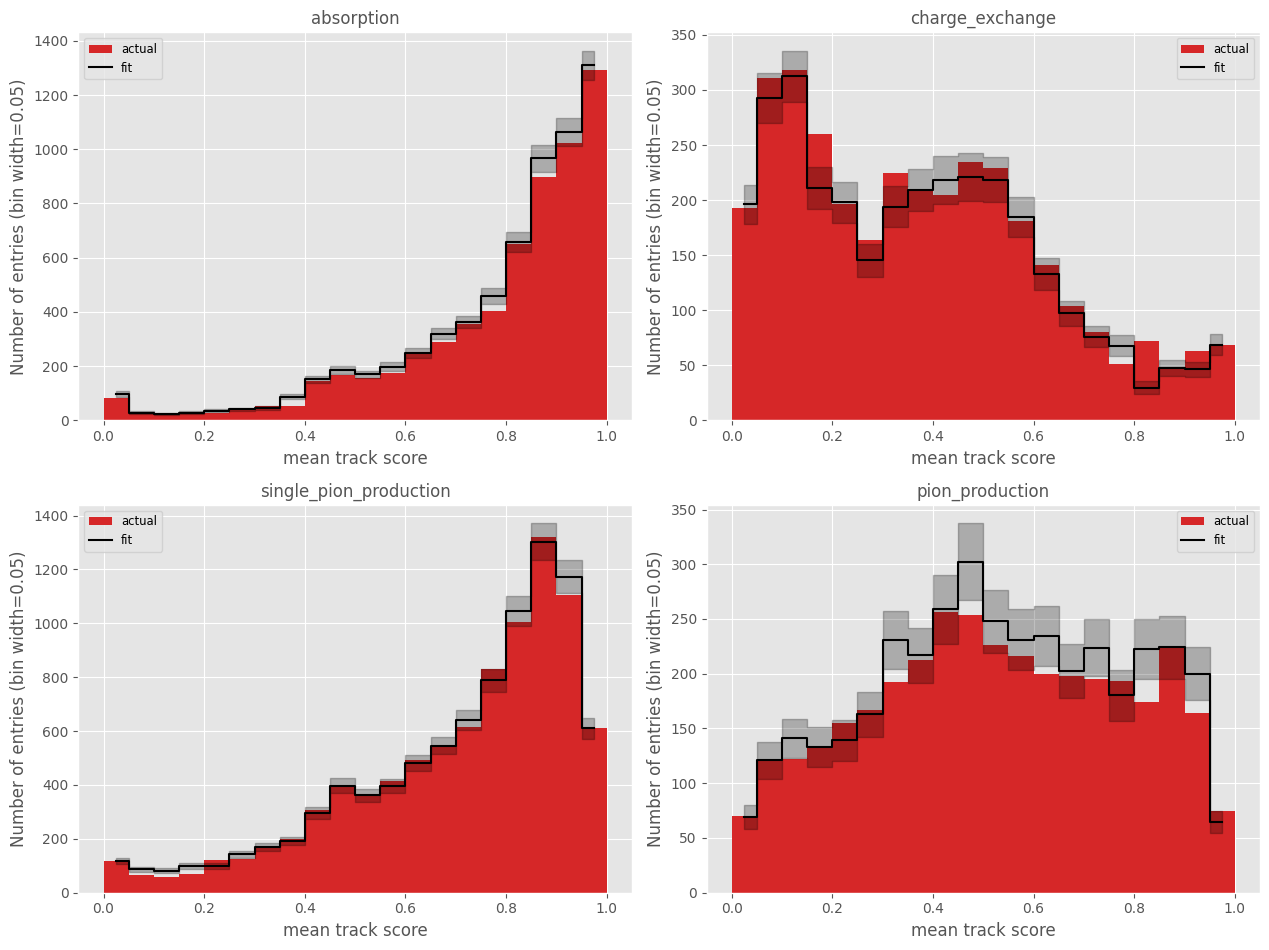

In [20]:
def FitStudyMC(mc_sample = cross_section.AnalysisInput, seed : int = 1, train_fraction : float = 0.5, book : Plots.PlotBook = None):
    train, test = cross_section.AnalysisInput.CreateTrainTestSamples(mc_sample, seed, train_fraction).values()
    print(f"template size {len(train.KE_init_true)}, data size {len(test.KE_init_true)}")
    region_fit_result = RegionFitMC(test, energy_slices, mean_track_score_bins, train, False)
    CompareFitResults(region_fit_result, test, book)
    return

book = Plots.PlotBook("mc_region_fit_mc_template.pdf", False)
FitStudyMC(analysis_input_mc_s, 10, 0.5, book)
book.close()

## Nll scan

In [299]:
def NllScan(param : str, fit_input : cross_section.AnalysisInput, energy_slice : cross_section.Slices, toy_template : cross_section.Toy, suggest_init : bool = True) -> cross_section.cabinetry.model_utils.ModelPrediction:
    mean_track_score_bins = np.linspace(0, 1, 21, True) #! make configurable

    model, _, _ = cross_section.RegionFit.CreateModel(toy_template, energy_slice, mean_track_score_bins, True)

    observed = cross_section.RegionFit.GenerateObservations(fit_input, energy_slice, mean_track_score_bins, model)

    if suggest_init is True:
        init_params = cex_analyse.CreateInitParams(model, fit_input, energy_slice, mean_track_score_bins)
    else:
        init_params = None

    return cross_section.cabinetry.fit.scan(model, observed, param, init_pars = init_params, custom_fit = True, tolerance = 0.01)

In [ ]:
for i in range(4):
    print(f"mu_{i}")
    region_fit_result = NllScan(f"mu_{i}", analysis_input_mc, energy_slices, args.toy_template, True)
    cross_section.cabinetry.visualize.scan(region_fit_result)

## toy template

In [25]:
def FitStudy(analysis_input, template_input : cross_section.AnalysisInput, book : Plots.PlotBook, template_weights : bool = None):
    region_fit_result = cex_analyse.RegionFit(analysis_input, energy_slices, mean_track_score_bins, template_input, suggest_init = False, beam_selection = False, template_weights = template_weights)
    # 6333.982696725586 # looked OK
    # 6248.008381092954 # looks bad
    CompareFitResults(region_fit_result, analysis_input, book)
    return region_fit_result

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 23, 'channel_1': 23, 'channel_2': 23, 'channel_3': 23, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_sample_0_pois_err', 'shapesys'), ('channel_0_sample_1_pois_err', 'shapesys'), ('channel_0_sample_2_pois_err', 'shapesys'), ('channel_0_sample_3_pois_err', 'shapesys'), ('channel_1_sample_0_pois_err', 'shapesys'), ('channel_1_sample_1_pois_err', 'shapesys'), ('channel_1_sample_2_pois_err', 'shapesys'), ('channel_1_sample_3_pois_err', 'shapesys'), ('channel_2_sample_0_pois_err', 'shapesys'), ('channel_2_sample_1_pois_err', 'shapesys'), ('channel_2_sample_2_pois_err', 'shapesys'), ('channel_2_sample_3_pois_err', 'shapesys'), ('channel_3_sample_0_pois_err', 'shapesys'), ('channel_3_sample_1_pois_err', 'shapesys'), ('channel_3_sample_2_pois_err', 'shapesys'), ('channel_3_sample_3_pois_err', 'shapesys'), ('mean_track_sco

total_yield_KE, sum(total_yield_KE)=(array([13440.95898754,  6368.02436649, 18164.54053341,  6808.6293573 ]), 
44782.153244744906)

actual_yield_KE, sum(actual_yield_KE)=([12375, 6414, 18109, 7101], 43999)

total_yield_score, sum(total_yield_score)=(array([13453.87329984,  6368.89251538, 18168.55744694,  6806.55538732]),
44797.87864948841)

actual_yield_score, sum(actual_yield_score)=([12375, 6414, 18109, 7101], 43999)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


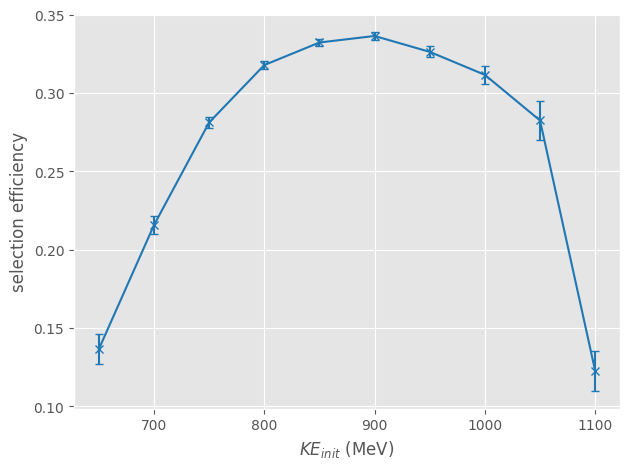

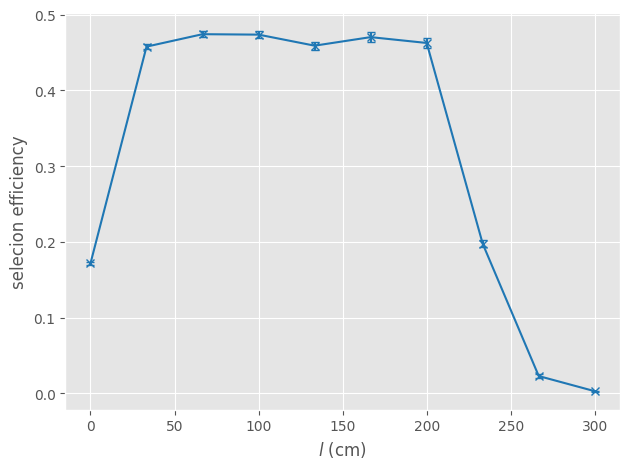

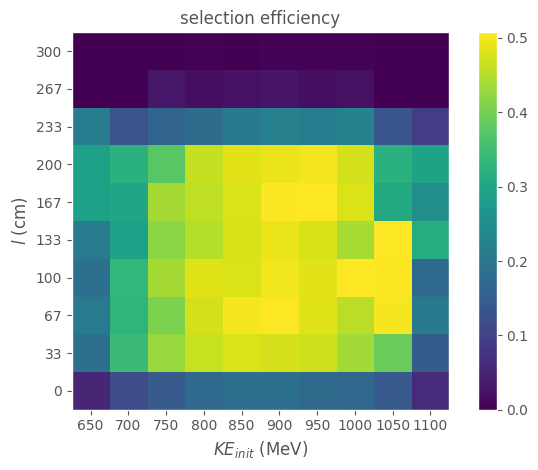

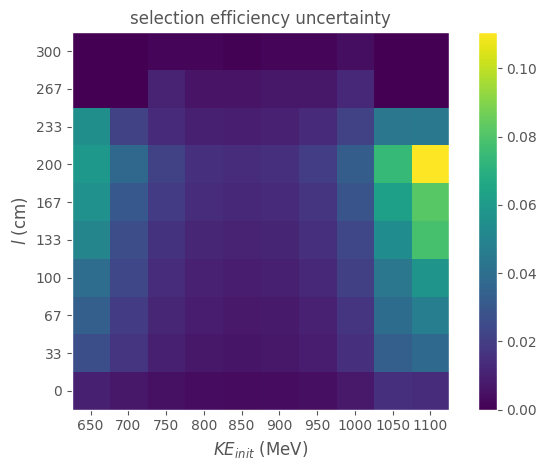

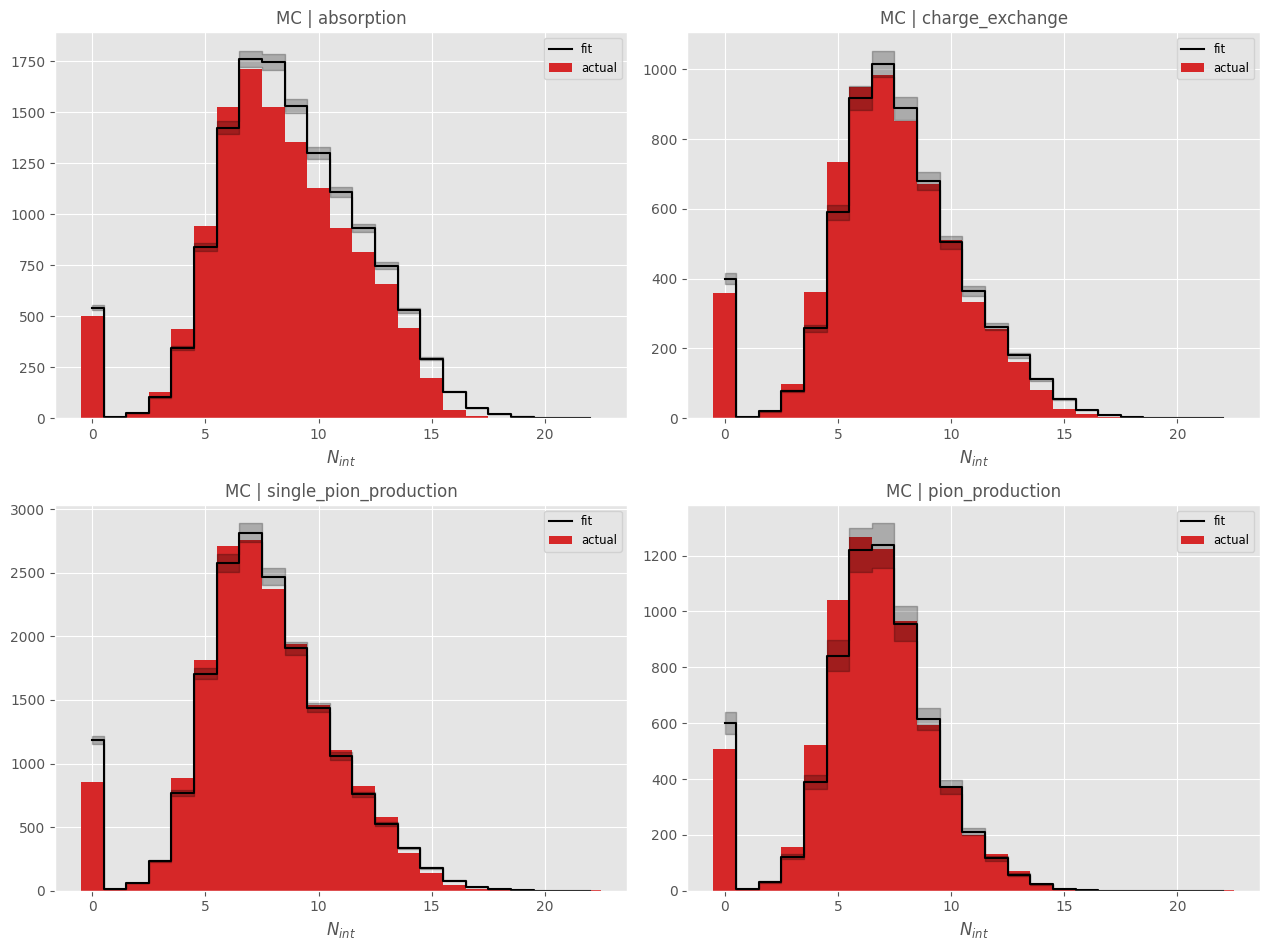

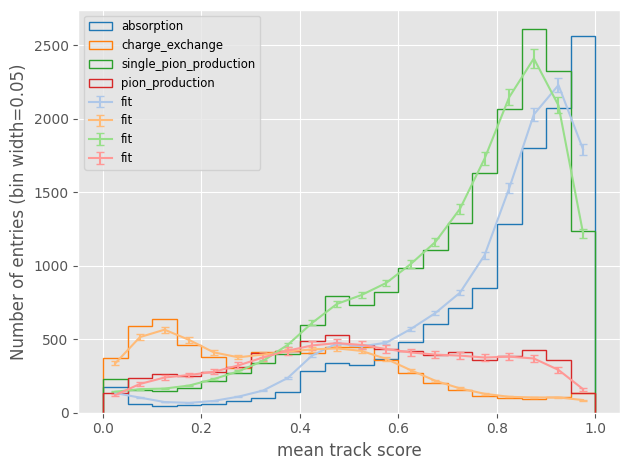

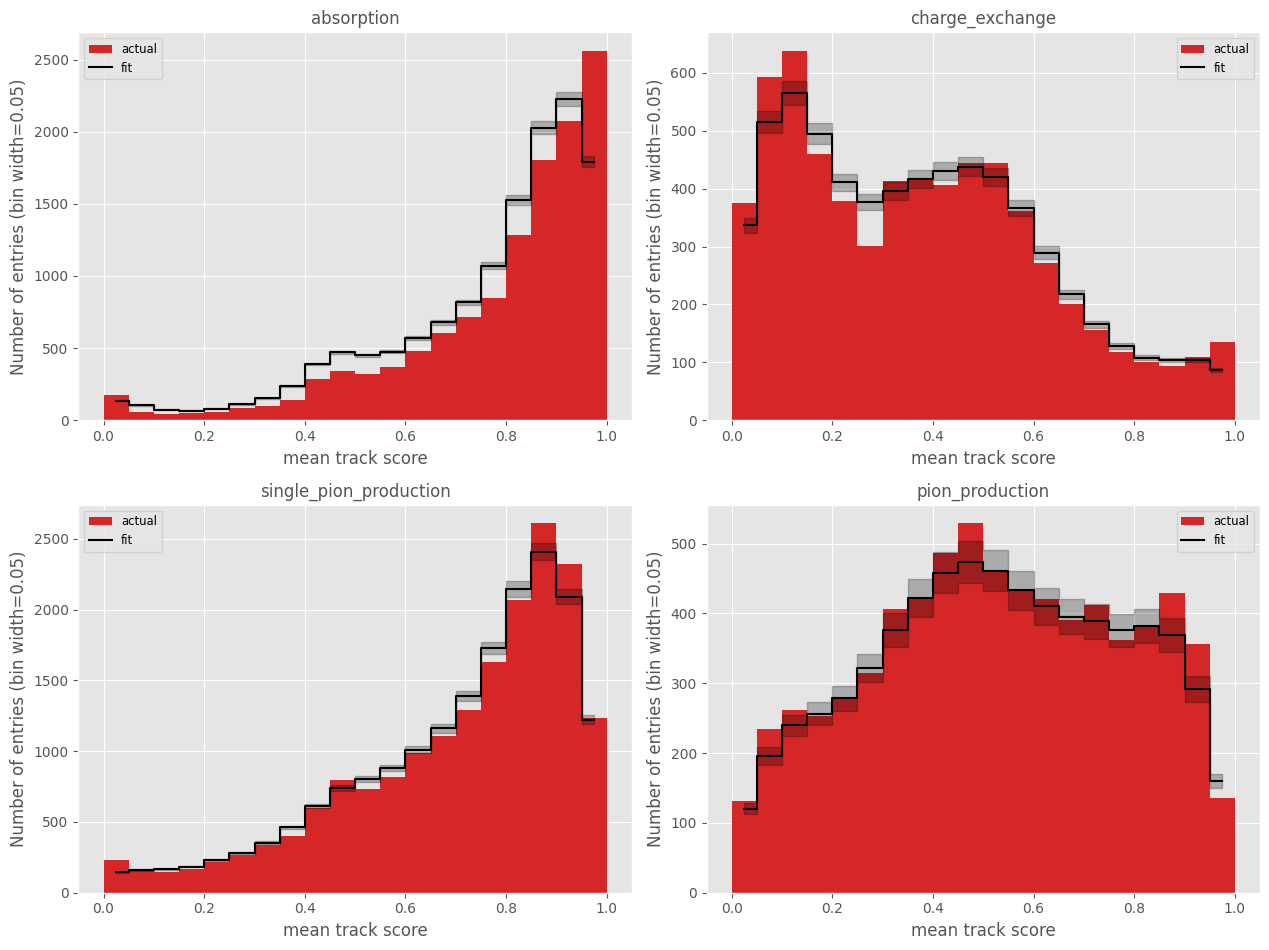

In [26]:
book = Plots.PlotBook("mc_region_fit_toy_template_unweighted.pdf", False)
fractions = EfficiencyMatrix(analysis_input_mc_s, analysis_input_mc, 10, book = book)
template_weights = CreateWeights(analysis_input_toy_template.KE_init_reco, analysis_input_toy_template.track_length_reco, fractions, 10)
FitStudy(analysis_input_mc_s, analysis_input_toy_template, book, template_weights)
book.close()

# Misc

(array([[1., 0., 1., ..., 0., 0., 0.],
        [6., 0., 0., ..., 0., 0., 0.],
        [1., 4., 3., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 [array([-250., -245., -240., -235., -230., -225., -220., -215., -210.,
         -205., -200., -195., -190., -185., -180., -175., -170., -165.,
         -160., -155., -150., -145., -140., -135., -130., -125., -120.,
         -115., -110., -105., -100.,  -95.,  -90.,  -85.,  -80.,  -75.,
          -70.,  -65.,  -60.,  -55.,  -50.,  -45.,  -40.,  -35.,  -30.,
          -25.,  -20.,  -15.,  -10.,   -5.,    0.,    5.,   10.,   15.,
           20.,   25.,   30.,   35.,   40.,   45.,   50.,   55.,   60.,
           65.,   70.,   75.,   80.,   85.,   90.,   95.,  100.,  105.,
          110.,  115.,  120.,  125.,  130.,  135.,  140.,  145.,  150.,
          155.,  160.,  165.,  170.,  175.,  180.,  185.,  190.,  195.,
          200.,  205.,  210.,  

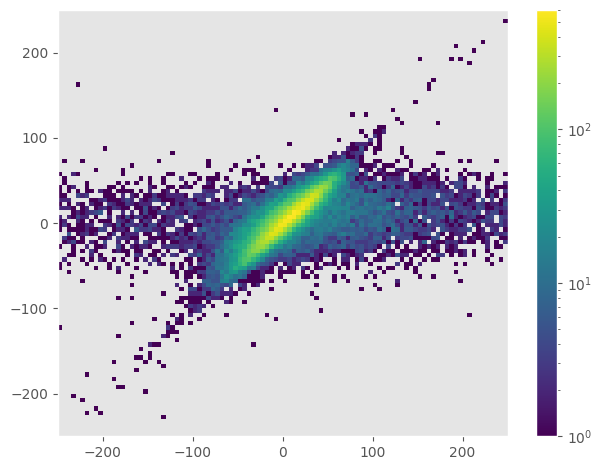

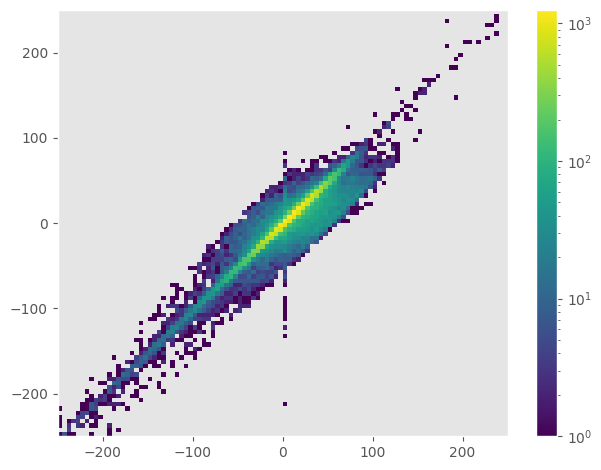

In [52]:
Plots.PlotHist2D(analysis_input_mc.KE_int_true - analysis_input_mc.KE_int_reco, analysis_input_mc.KE_init_true - analysis_input_mc.KE_init_reco, x_range = [-250, 250], y_range = [-250, 250])
Plots.PlotHist2D(analysis_input_toy.KE_int_true - analysis_input_toy.KE_int_reco, analysis_input_toy.KE_init_true - analysis_input_toy.KE_init_reco, x_range = [-250, 250], y_range = [-250, 250])

In [132]:
# templates = []
# for c in args.toy_template.reco_regions:
#     samples = []
#     for s in args.toy_template.truth_regions:
#         samples.append(np.array([sum(args.toy_template.reco_regions[c] & args.toy_template.truth_regions[s])]))
#     templates.append(samples)

# templates_mean_track_score = np.array([[sum(args.toy_template.truth_regions[i])] for i in args.toy_template.truth_regions])

mean_track_score_bins = np.array([0, 1])
energy_slices = cross_section.Slices(100, 0, 1050, True)
templates = cross_section.RegionFit.CreateKEIntTemplates(args.toy_template, energy_slices)
templates_mean_track_score = cross_section.RegionFit.CreateMeanTrackScoreTemplates(args.toy_template, mean_track_score_bins)

In [133]:
model = cross_section.RegionFit.Model(len(templates), templates, None, False)
cross_section.RegionFit.PrintModelSpecs(model)

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 11, 'channel_1': 11, 'channel_2': 11, 'channel_3': 11}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []


In [134]:
# observed_data = np.concatenate([[sum(i)] for i in analysis_input_mc_s.regions.values()] + [[len(analysis_input_mc_s.mean_track_score)]] + [model.config.auxdata])
# observed_data = observed_data.astype(int)
observed_data = cross_section.RegionFit.GenerateObservations(analysis_input_mc_s, energy_slices, None, model)
print(observed_data)

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-7400720.96949315])


[3.000e+00 7.120e+02 4.676e+03 6.681e+03 4.712e+03 2.733e+03 1.358e+03
 2.540e+02 1.700e+01 0.000e+00 5.000e+00 1.000e+00 2.400e+01 2.140e+02
 3.000e+02 1.590e+02 9.000e+01 3.100e+01 5.000e+00 1.000e+00 0.000e+00
 0.000e+00 8.000e+00 4.930e+02 3.249e+03 4.398e+03 2.703e+03 1.462e+03
 7.370e+02 1.690e+02 8.000e+00 0.000e+00 1.000e+00 4.000e+00 1.090e+02
 6.080e+02 7.190e+02 4.560e+02 3.090e+02 1.760e+02 4.300e+01 4.000e+00
 1.000e+00 2.000e+00]

In [135]:
result = cross_section.RegionFit.Fit(observed_data, model, None, True)
print(result)

prediction = cross_section.cabinetry.model_utils.prediction(model, fit_results = result)
print(prediction)

init_params=None
model.config.poi_index=0
result=FitResults(bestfit=array([0.00195526, 0.00828961, 0.00540056, 0.00686436]), uncertainty=array([0.0001686 , 0.00037075, 0.00015959, 0.00046822]), labels=['mu_0', 'mu_1', 'mu_2', 'mu_3'], corr_mat=[[ 1.         -0.82055436 -0.61971191  0.51075925]
 [-0.82055436  1.          0.50150734 -0.62392789]
 [-0.61971191  0.50150734  1.         -0.85317171]
 [ 0.51075925 -0.62392789 -0.85317171  1.        ]], best_twice_nll=3297.360646590064, goodness_of_fit=-1, minos_uncertainty={})


FitResults(
    bestfit=array([0.00195526, 0.00828961, 0.00540056, 0.00686436]),
    uncertainty=array([0.0001686 , 0.00037075, 0.00015959, 0.00046822]),
    labels=['mu_0', 'mu_1', 'mu_2', 'mu_3'],
    corr_mat=[[ 1.         -0.82055436 -0.61971191  0.51075925]
 [-0.82055436  1.          0.50150734 -0.62392789]
 [-0.61971191  0.50150734  1.         -0.85317171]
 [ 0.51075925 -0.62392789 -0.85317171  1.        ]],
    best_twice_nll=3297.360646590064,
    goodness_of_fit=-1,
    minos_uncertainty={}
)

ModelPrediction(
    model=<pyhf.pdf.Model object at 0x7f0db5d62e30>,
    model_yields=[
        [
            [
                7.740873080542789,
                88.65147397620865,
                569.2640800794721,
                892.1458876458862,
                721.4888673521617,
                533.4163490719775,
                374.3090477190881,
                237.0811022063791,
                141.89710563302634,
                73.0582780132562,
                14.887347217795604
            ],
            [
                24.71133087449512,
                291.1643024608408,
                1695.3664060580738,
                2141.082219026827,
                1324.8871039973774,
                718.7258669843931,
                372.1123554596482,
                193.50439335905384,
                103.40460963718621,
                34.41846554542225,
                3.6059808555536317
            ],
            [
                24.02709491934454,
                289.9291055844036,
                1605.5435160174818,
                1966.047149901727,
                1235.9939428233015,
                689.7920264482357,
                363.9383905416294,
                208.20241926962703,
                118.42349682881256,
                38.171163607535895,
                3.137725814371584
            ],
            [
                17.867920017118468,
                205.18934504483488,
                1078.4315951630479,
                1137.6298057768126,
                506.774848676068,
                171.22450899231774,
                45.421447081549324,
                7.118337709470553,
                0.3706752519878591,
                0.006864356518293687,
                0.0
            ]
        ],
        [
            [
                0.005865779045624745,
                0.02737363554624881,
                0.18966018914186675,
                0.30306525069061185,
                0.18770492945999184,
                0.16033129391374304,
                0.09971824377562066,
                0.0645235695018722,
                0.04301571300124813,
                0.013686817773124405,
                0.001955259681874915
            ],
            [
                3.2743964090659414,
                40.08026996919956,
                234.83639461374443,
                294.2065897573654,
                182.5206585691491,
                99.68257422536189,
                51.64427754045776,
                26.468728440879875,
                14.009442864104914,
                4.766526418260548,
                0.580272781353458
            ],
            [
                0.35103645083330975,
                3.75879030430744,
                20.8623663010627,
                25.128809318882926,
                16.250287393191215,
                9.0999449177558,
                4.887507507756082,
                2.9001011399613437,
                1.4905547758460538,
                0.5886611252435502,
                0.043204486256407354
            ],
            [
                1.3728713036587374,
                14.758366514331426,
                78.05459796951752,
                82.35168514996936,
                36.374225190438246,
                12.348977376410343,
                3.226247563598033,
                0.48736931279885176,
                0.027457426073174748,
                0.0,
                0.0
            ]
        ],
        [
            [
                2.004141173921788,
                21.568469550762188,
                139.99659322224392,
                218.04078342428116,
                175.24797002676675,
                130.67195979938245,
                92.05949160171663,
                58.24914118273559,
                34.561170136821,
                17.95710491833922,
                3.6758882019248404
            ],
            [
                3.7883523011218614,
                46.43011211943883,
                267.0995612569967,

In [136]:
print(templates)
print(prediction.model_yields)
actual = []
for c in analysis_input_mc_s.regions.values():
    samples = []
    for s in analysis_input_mc_s.exclusive_process.values():
        samples.append(analysis_input_mc_s.NInteract(energy_slices, s, c)[1:])
    actual.append(samples)
print(np.array(actual))
print([[sum(s)] for s in analysis_input_mc_s.exclusive_process.values()])

[
    [
        array([  3959,  45340, 291145, 456280, 368999, 272811, 191437, 121253,
        72572,  37365,   7614]),
        array([  2981,  35124, 204517, 258285, 159825,  86702,  44889,  23343,
        12474,   4152,    435]),
        array([  4449,  53685, 297292, 364045, 228864, 127726,  67389,  38552,
        21928,   7068,    581]),
        array([  2603,  29892, 157106, 165730,  73827,  24944,   6617,   1037,
           54,      1,      0])
    ],
    [
        array([  3,  14,  97, 155,  96,  82,  51,  33,  22,   7,   1]),
        array([  395,  4835, 28329, 35491, 22018, 12025,  6230,  3193,  1690,
         575,    70]),
        array([  65,  696, 3863, 4653, 3009, 1685,  905,  537,  276,  109,    8]),
        array([  200,  2150, 11371, 11997,  5299,  1799,   470,    71,     4,
           0,     0])
    ],
    [
        array([  1025,  11031,  71600, 111515,  89629,  66831,  47083,  29791,
        17676,   9184,   1880]),
        array([  457,  5601, 32221, 40193, 24514, 13575,  7036,  3601,  1900,
         662,    82]),
        array([  6208,  72914, 401749, 491431, 310139, 172182,  91297,  52198,
        29762,   9355,    683]),
        array([  2171,  25065, 135383, 142363,  63463,  21625,   5949,    911,
           47,      0,      0])
    ],
    [
        array([  184,  2073, 13677, 21522, 17326, 12617,  8988,  5656,  3287,
        1758,   335]),
        array([ 106, 1297, 7625, 9503, 5927, 3195, 1641,  875,  438,  148,   23]),
        array([  820,  9644, 53400, 65364, 41142, 22700, 12056,  6932,  4089,
        1277,   105]),
        array([  690,  9072, 47284, 49891, 22303,  7577,  2039,   318,    20,
           0,     0])
    ]
]

[
    [
        [
            7.740873080542789,
            88.65147397620865,
            569.2640800794721,
            892.1458876458862,
            721.4888673521617,
            533.4163490719775,
            374.3090477190881,
            237.0811022063791,
            141.89710563302634,
            73.0582780132562,
            14.887347217795604
        ],
        [
            24.71133087449512,
            291.1643024608408,
            1695.3664060580738,
            2141.082219026827,
            1324.8871039973774,
            718.7258669843931,
            372.1123554596482,
            193.50439335905384,
            103.40460963718621,
            34.41846554542225,
            3.6059808555536317
        ],
        [
            24.02709491934454,
            289.9291055844036,
            1605.5435160174818,
            1966.047149901727,
            1235.9939428233015,
            689.7920264482357,
            363.9383905416294,
            208.20241926962703,
            118.42349682881256,
            38.171163607535895,
            3.137725814371584
        ],
        [
            17.867920017118468,
            205.18934504483488,
            1078.4315951630479,
            1137.6298057768126,
            506.774848676068,
            171.22450899231774,
            45.421447081549324,
            7.118337709470553,
            0.3706752519878591,
            0.006864356518293687,
            0.0
        ]
    ],
    [
        [
            0.005865779045624745,
            0.02737363554624881,
            0.18966018914186675,
            0.30306525069061185,
            0.18770492945999184,
            0.16033129391374304,
            0.09971824377562066,
            0.0645235695018722,
            0.04301571300124813,
            0.013686817773124405,
            0.001955259681874915
        ],
        [
            3.2743964090659414,
            40.08026996919956,
            234.83639461374443,
            294.2065897573654,
            182.5206585691491,
            99.68257422536189,
            51.64427754045776,
            26.468728440879875,
            14.009442864104914,
            4.766526418260548,
            0.580272781353458
        ],
        [
            0.35103645083330975,
            3.75879030430744,
            20.8623663010627,
            25.128809318882926,
            16.250287393191215,
            9.0999449177558,
            4.887507507756082,
            2.9001011399613437,
            1.4905547758460538,
            0.5886611252435502,
            0.043204486256407354
        ],
        [
            1.3728713036587374,
            14.758366514331426,
            78.05459796951752,
            82.35168514996936,
            36.374225190438246,
            12.348977376410343,
            3.226247563598033,
            0.48736931279885176,
            0.027457426073174748,
            0.0,
            0.0
        ]
    ],
    [
        [
            2.004141173921788,
            21.568469550762188,
            139.99659322224392,
            218.04078342428116,
            175.24797002676675,
            130.67195979938245,
            92.05949160171663,
            58.24914118273559,
            34.561170136821,
            17.95710491833922,
            3.6758882019248404
        ],
        [
            3.7883523011218614,
            46.43011211943883,
            267.0995612569967,
            333.18434144199335,
            203.21152802998097,
            112.53147152675989,
            58.325704137184715,
            29.850889795054318,
            15.750261208165288,
            5.487722589371274,
            0.6797481152997651
        ],
        [
            33.5266813349721,
            393.7764888624607,
            2169.6698936281746,
            2654.002985684065,
            1674.92452038449,
            929.8793565750914,
            493.05499771890277,
            281.89847170149386,
            160.73148999539947,
            50.52224611608635,
   

[[[   0  215 1514 2496 1946 1341  787  148    7    0    1]
  [   0  174 1034 1337  879  420  175   24    2    0    0]
  [   2  196 1330 1908 1384  794  349   79    7    0    3]
  [   1  127  798  940  503  178   47    3    1    0    1]]

 [[   0    2    0    0    0    1    0    0    0    0    0]
  [   1   12  141  202  107   69   23    3    1    0    0]
  [   0    5   18   19   22   11    6    2    0    0    0]
  [   0    5   55   79   30    9    2    0    0    0    0]]

 [[   0   42  370  574  447  321  241   70    2    0    1]
  [   0   23  151  212  157   73   30    7    1    0    0]
  [   4  292 2014 2758 1772  958  434   90    5    0    0]
  [   4  136  714  854  327  110   32    2    0    0    0]]

 [[   0   13   57   80   89   83   74   22    2    1    1]
  [   0    6   32   46   38   28   12    5    0    0    0]
  [   2   43  233  331  224  164   82   16    2    0    1]
  [   2   47  286  262  105   34    8    0    0    0    0]]]

[[12375], [6414], [18109], [7101]]